In [ ]:
import itertools
import torch
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from skorch import NeuralNetBinaryClassifier

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

dtype = torch.float
device = torch.device("cpu")

## Defining resources
We define some relevant functions and costant variables to use in this notebook.

In [ ]:
#define a function that split target column from dataset.
def split_train_test(df_monk_train, df_monk_test):
    target_train = df_monk_train[['class']]
    df_monk_train.drop(labels='class', axis=1, inplace=True)
    target_test = df_monk_test[['class']]
    df_monk_test.drop(labels='class', axis=1, inplace=True)
    X_train = df_monk_train.values #returns a ndarray
    y_train = target_train.values.ravel() #flattens the array into a 1-dimensional array
    X_test = df_monk_test.values
    y_test = target_test.values.ravel()

    return X_train, y_train, X_test, y_test

In [ ]:
#define mee loss function 
def mee(true_target, predicted_target):  # assuming target is 2-dim matrix with x and y as columns
    l = true_target.shape[0]
    res = 0

    for p in range(l):  # for p-th pattern in l (number of samples)
        x_diff = np.square(true_target[p, 0] - predicted_target[p, 0])  # difference between the x value of the true and predicted target
        y_diff = np.square(
            true_target[p, 1] - predicted_target[p, 1])  # difference between the y values of true and predicted target
        sum_term = x_diff + y_diff
        res = res + np.sqrt(sum_term)
    res = res / l

    return res

In [ ]:
#define a neural network
class BinaryClassification(nn.Module):
    def __init__(self, n_input = 6, hidden_units = 100):
        super(BinaryClassification, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_input, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, 1)
        )

        self.layer_in = nn.Linear(n_input, hidden_units)
        self.relu = nn.ReLU(inplace=True)
        self.layer_out = nn.Linear(hidden_units, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, inputs, **kwargs):
        #x = self.relu(self.layer_in(inputs))
        #x = self.layer_in(inputs)
        #x = self.sigmoid(self.layer_out(x))
        x = self.layers(inputs)

        return x

In [ ]:
def plot_learning_curves(train_scores, test_scores, epochs, y_label):
    plt.figure(figsize=(10,8))
    plt.plot(range(0,epochs), train_scores, label = "Training error", linestyle='dashed')
    plt.plot(range(0,epochs), test_scores, label = "Test error")
    plt.legend()
    plt.ylabel(y_label)
    plt.xlabel('Epoch');

## Loading MONK-1 dataset
Now we load the first MONK dataset.

In [ ]:
#read train dataset
df_monk1_train = pd.read_csv('./data/MONK/monks-1.train', sep=" ", skipinitialspace=True, names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk1_train.drop(labels='id', axis=1, inplace=True)

#read test dataset
df_monk1_test = pd.read_csv('./data/MONK/monks-1.test', sep=" ", skipinitialspace=True,  names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk1_test.drop(labels='id', axis=1, inplace=True)

In [ ]:
df_monk1_test #first column is the target (can be either 0 or 1)

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,2
2,1,1,1,1,1,2,1
3,1,1,1,1,1,2,2
4,1,1,1,1,1,3,1
...,...,...,...,...,...,...,...
427,1,3,3,2,3,2,2
428,1,3,3,2,3,3,1
429,1,3,3,2,3,3,2
430,1,3,3,2,3,4,1


In [ ]:
df_monk1_train

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,3,1
1,1,1,1,1,1,3,2
2,1,1,1,1,3,2,1
3,1,1,1,1,3,3,2
4,1,1,1,2,1,2,1
...,...,...,...,...,...,...,...
119,1,3,3,2,1,4,2
120,1,3,3,2,3,1,2
121,1,3,3,2,3,2,2
122,1,3,3,2,3,3,2


<AxesSubplot:ylabel='class'>

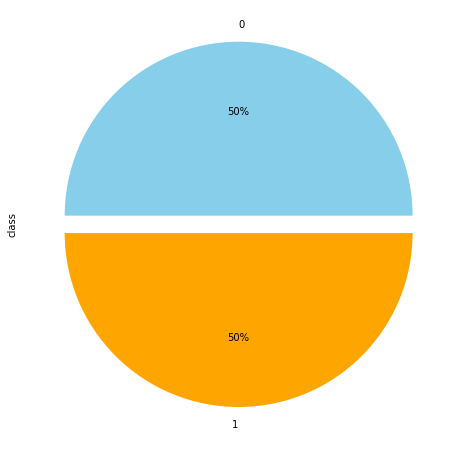

In [ ]:
#plot class distribution in train data
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

df_monk1_train['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

<AxesSubplot:ylabel='class'>

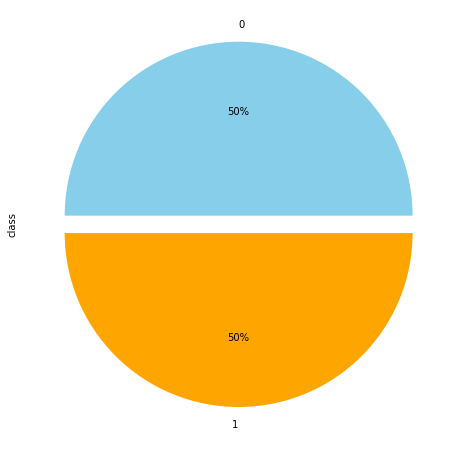

In [ ]:
#plot class distribution in test data
df_monk1_test['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

In [ ]:
X_train_M1, y_train_M1, X_test_M1, y_test_M1 = split_train_test(df_monk1_train, df_monk1_test)

### Using skorch and sklearn
In this part, use skorch and sklearn to define a good model with MONKs

In [ ]:
#trains the model with one iteration (epoch) and computes in output a list of train and test scores using MEE
def fit_and_score_monk(epochs, eval_model, X_train, y_train, X_test, y_test):
    train_scores = []
    test_scores = []
    train_loss = []
    test_loss = []

    for i in range(epochs):
        eval_model = eval_model.partial_fit(X_train,y_train, classes = np.unique(y_train))
        y_train_predicted = eval_model.predict(X_train)
        y_test_predicted = eval_model.predict(X_test)
        #results on train set
        train_loss.append(log_loss(y_train, y_train_predicted))
        train_scores.append(accuracy_score(y_train, y_train_predicted))
        #result on test set
        test_loss.append(log_loss(y_test, y_test_predicted))
        test_scores.append(accuracy_score(y_test, y_test_predicted))
    return train_scores, test_scores, train_loss, test_loss

### One hot encoding in MONK-1
In the MONK dataset we have the categories encoded using label encoding (e.g. 0,1,2,..), we need to use one hot encoding in order to have better results (e.g. 001, 010, ..). 

In [ ]:
enc_train = OneHotEncoder()
enc_train.fit(X_train_M1)
X_train_M1 = enc_train.transform(X_train_M1).toarray()
print(X_train_M1.shape)

enc_test = OneHotEncoder()
enc_test.fit(X_test_M1)
X_test_M1 = enc_test.transform(X_test_M1).toarray()
print(X_test_M1.shape)

(124, 17)
(432, 17)


In [ ]:
#cast train set and test set to Float
X_trainFit_enc = X_train_M1.astype(np.single)
y_trainFit_enc = y_train_M1.astype(np.single)

X_testFit_enc = X_test_M1.astype(np.single)
y_testFit_enc = y_test_M1.astype(np.single)

In [ ]:
net_enc = NeuralNetBinaryClassifier(
    BinaryClassification,
    module__n_input=X_trainFit_enc.shape[1],
    module__hidden_units=150,
    max_epochs=1,
    batch_size = 1,
    lr = 0.001,
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=0.0001,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    train_split=None
)

#net_enc.fit(X_trainFit_enc, y_trainFit_enc, verbose=0)
train_scores_M1, test_scores_M1, train_loss_M1, test_loss_M1 = fit_and_score_monk(25, net_enc, X_trainFit_enc, y_trainFit_enc, X_testFit_enc, y_testFit_enc)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.6790  0.2496
      2        0.5980  0.1147
      3        0.5172  0.1148
      4        0.4514  0.1321
      5        0.3973  0.1197
      6        0.3468  0.1160
      7        0.2940  0.1163
      8        0.2513  0.1146
      9        0.2081  0.1195
     10        0.1690  0.1167
     11        0.1341  0.1155
     12        0.1073  0.1160
     13        0.0846  0.1157
     14        0.0678  0.1169
     15        0.0549  0.1098
     16        0.0443  0.1153
     17        0.0367  0.1338
     18        0.0305  0.1287
     19        0.0254  0.1332
     20        0.0214  0.1086
     21        0.0184  0.1217
     22        0.0160  0.1196
     23        0.0139  0.1207
     24        0.0120  0.1240
     25        0.0106  0.1239


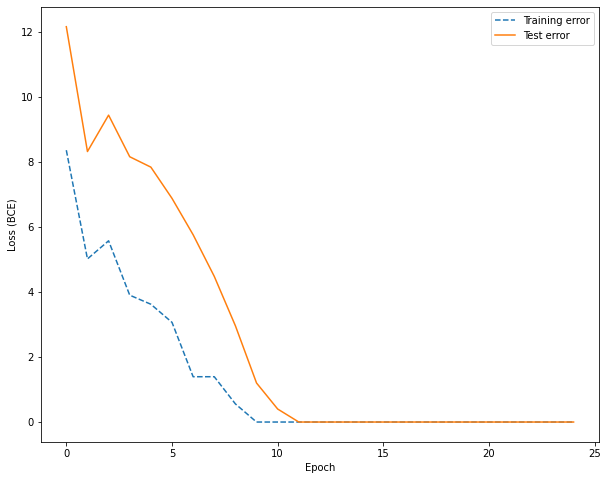

In [ ]:
plot_learning_curves(train_loss_M1, test_loss_M1, 25, 'Loss (BCE)')

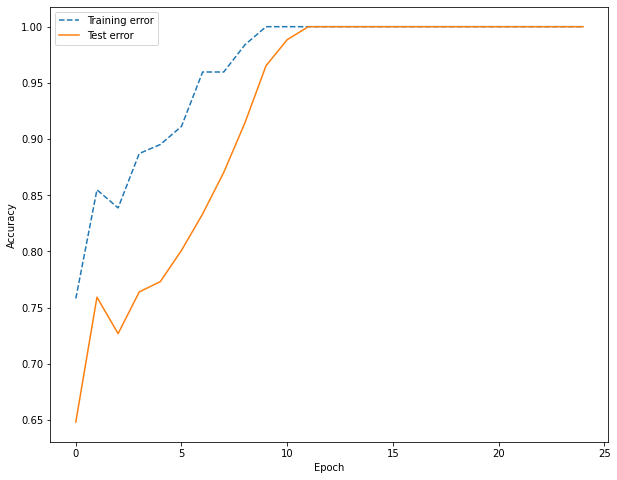

In [ ]:
plot_learning_curves(train_scores_M1, test_scores_M1, 25, 'Accuracy')

In [ ]:
#control the accuracy between true and predict values on test data
#print(classification_report(y_testFit_enc, test_scores_M1))

### Loading MONK-2 dataset

In [ ]:
df_monk2_train = pd.read_csv('./data/MONK/monks-2.train', sep=" ", skipinitialspace=True, names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk2_train.drop(labels='id', axis=1, inplace=True)

df_monk2_test = pd.read_csv('./data/MONK/monks-2.test', sep=" ", skipinitialspace=True,  names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk2_test.drop(labels='id', axis=1, inplace=True)

In [ ]:
df_monk2_test.head() #first column is the target (can be either 0 or 1)

,class,a1,a2,a3,a4,a5,a6
0,0,1,1,1,1,1,1
1,0,1,1,1,1,1,2
2,0,1,1,1,1,2,1
3,0,1,1,1,1,2,2
4,0,1,1,1,1,3,1


In [ ]:
df_monk2_train

,class,a1,a2,a3,a4,a5,a6
0,0,1,1,1,1,2,2
1,0,1,1,1,1,4,1
2,0,1,1,1,2,1,1
3,0,1,1,1,2,1,2
4,0,1,1,1,2,2,1
...,...,...,...,...,...,...,...
164,0,3,3,2,2,3,1
165,0,3,3,2,2,3,2
166,1,3,3,2,3,1,1
167,0,3,3,2,3,2,1


<AxesSubplot:ylabel='class'>

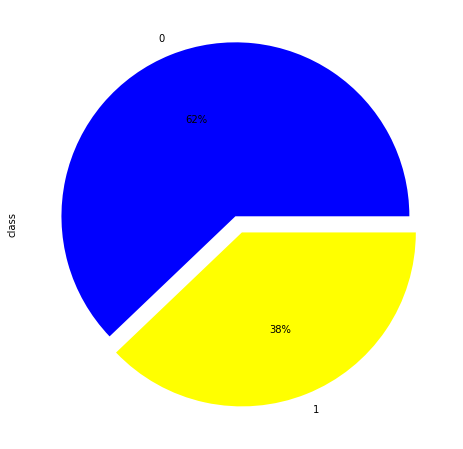

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

df_monk2_train['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'yellow'], explode=(0.05, 0.05))

<AxesSubplot:ylabel='class'>

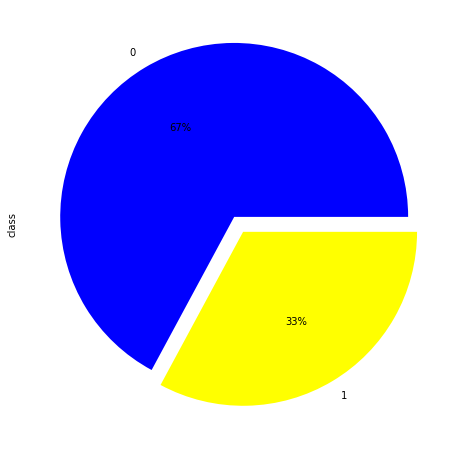

In [ ]:
df_monk2_test['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'yellow'], explode=(0.05, 0.05))

In [ ]:
X_train_M2, y_train_M2, X_test_M2, y_test_M2 = split_train_test(df_monk2_train, df_monk2_test)

In [ ]:
enc_train = OneHotEncoder()
enc_train.fit(X_train_M2)
X_train_M2 = enc_train.transform(X_train_M2).toarray()
print(X_train_M2.shape)

enc_test = OneHotEncoder()
enc_test.fit(X_test_M2)
X_test_M2 = enc_test.transform(X_test_M2).toarray()
print(X_test_M2.shape)


(169, 17)
(432, 17)


In [ ]:
#cast train set and test set to Float
X_trainFit2 = X_train_M2.astype(np.single)
y_trainFit2 = y_train_M2.astype(np.single)

X_testFit2 = X_test_M2.astype(np.single)
y_testFit2 = y_test_M2.astype(np.single)

In [ ]:
net_enc2 = NeuralNetBinaryClassifier(
    BinaryClassification,
    module__n_input=X_trainFit2.shape[1],
    module__hidden_units=100,
    max_epochs=1,
    batch_size = 1,
    lr = 0.001,
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=0.0001,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    train_split=None
)

#net_enc2.fit(X_trainFit2, y_trainFit2, verbose=0)
train_scores_M2, test_scores_M2, train_loss_M2, test_loss_M2 = fit_and_score_monk(35, net_enc2, X_trainFit2, y_trainFit2, X_testFit2, y_testFit2)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.6750  0.1508
      2        0.6484  0.1656
      3        0.6270  0.1706
      4        0.5970  0.1462
      5        0.5640  0.1528
      6        0.5159  0.1454
      7        0.4609  0.1462
      8        0.4003  0.1473
      9        0.3416  0.1438
     10        0.2914  0.1602
     11        0.2383  0.1578
     12        0.2029  0.1465
     13        0.1662  0.1471
     14        0.1373  0.1496
     15        0.1159  0.1741
     16        0.0982  0.1468
     17        0.0817  0.1557
     18        0.0681  0.1575
     19        0.0573  0.1499
     20        0.0481  0.1498
     21        0.0404  0.1608
     22        0.0346  0.1484
     23        0.0295  0.1509
     24        0.0254  0.1517
     25        0.0222  0.1450
     26        0.0191  0.1561
     27        0.0166  0.1451
     28        0.0148  0.1445
     29        0.0128  0.1497
     30        0.0113  0.1463
     31        0.0100  0.1566
     32   

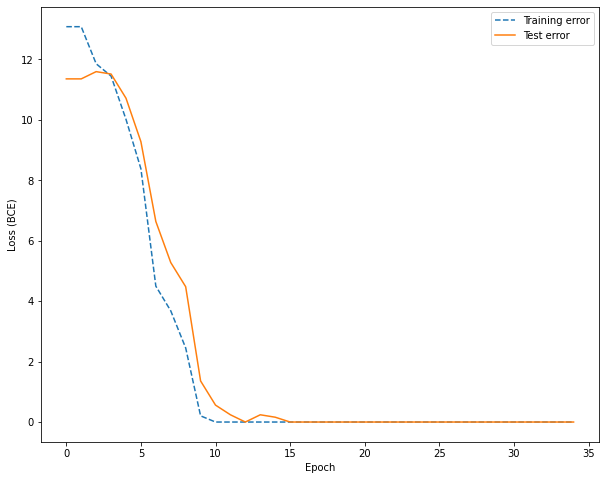

In [ ]:
plot_learning_curves(train_loss_M2, test_loss_M2, 35, 'Loss (BCE)')

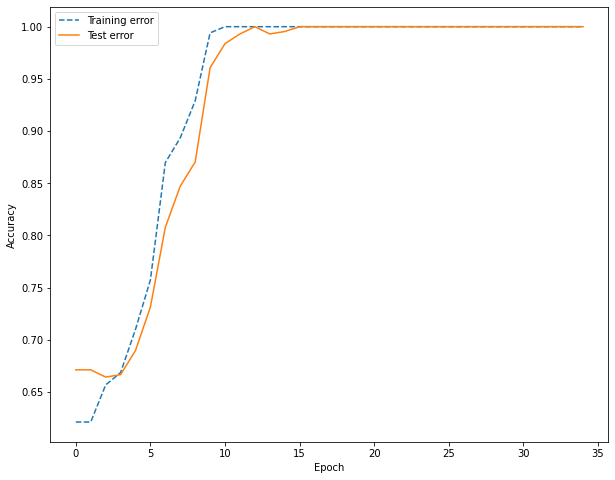

In [ ]:
plot_learning_curves(train_scores_M2, test_scores_M2, 35, 'Accuracy')

## Loading MONK-3 dataset

In [ ]:
#read train dataset
df_monk3_train = pd.read_csv('./data/MONK/monks-3.train', sep=" ", skipinitialspace=True, names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk3_train.drop(labels='id', axis=1, inplace=True)

#read test dataset
df_monk3_test = pd.read_csv('./data/MONK/monks-3.test', sep=" ", skipinitialspace=True,  names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk3_test.drop(labels='id', axis=1, inplace=True)

In [ ]:
df_monk3_train.head()

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,1,2
1,1,1,1,1,1,2,1
2,1,1,1,1,1,2,2
3,0,1,1,1,1,3,1
4,0,1,1,1,1,4,1


In [ ]:
df_monk3_test.head()

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,2
2,1,1,1,1,1,2,1
3,1,1,1,1,1,2,2
4,1,1,1,1,1,3,1


<AxesSubplot:ylabel='class'>

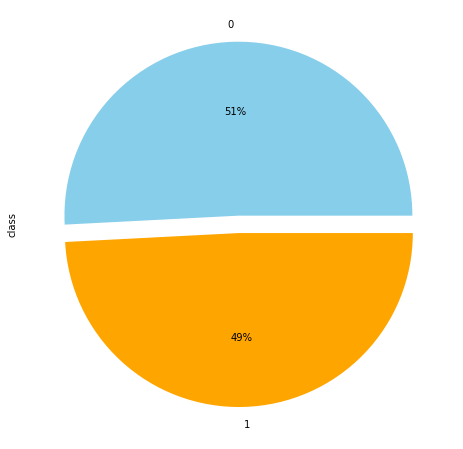

In [ ]:
#plot class distribution in train data
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

df_monk3_train['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

<AxesSubplot:ylabel='class'>

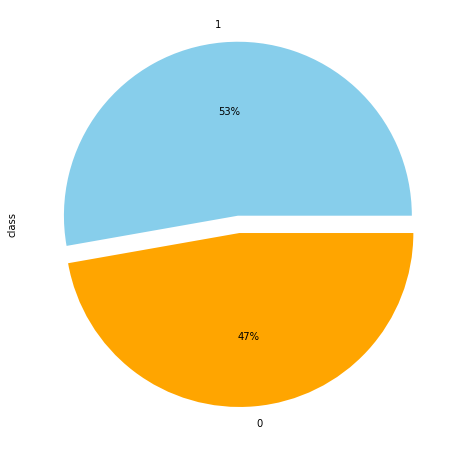

In [ ]:
#plot class distribution in test data
df_monk3_test['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

In [ ]:
X_train_M3, y_train_M3, X_test_M3, y_test_M3 = split_train_test(df_monk3_train, df_monk3_test)

In [ ]:
enc_train = OneHotEncoder()
enc_train.fit(X_train_M3)
X_train_M3 = enc_train.transform(X_train_M3).toarray()
print(X_train_M3.shape)

enc_test = OneHotEncoder()
enc_test.fit(X_test_M3)
X_test_M3 = enc_test.transform(X_test_M3).toarray()
print(X_test_M3.shape)

(122, 17)
(432, 17)


In [ ]:
#cast train set and test set to Float
X_trainFit3 = X_train_M3.astype(np.single)
y_trainFit3 = y_train_M3.astype(np.single)

X_testFit3 = X_test_M3.astype(np.single)
y_testFit3 = y_test_M3.astype(np.single)

In [ ]:
net_enc3 = NeuralNetBinaryClassifier(
    BinaryClassification,
    module__n_input=X_trainFit3.shape[1],
    module__hidden_units=25,
    max_epochs=1,
    batch_size = 1,
    lr = 0.001,
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=0.0001,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    train_split=None
)

#net_enc3.fit(X_trainFit3, y_trainFit3, verbose=0)
train_scores_M3, test_scores_M3, train_loss_M3, test_loss_M3 = fit_and_score_monk(50, net_enc3, X_trainFit3, y_trainFit3, X_testFit3, y_testFit3)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.6851  0.0993
      2        0.6360  0.0976
      3        0.5703  0.0974
      4        0.4903  0.0983
      5        0.4102  0.0991
      6        0.3558  0.0994
      7        0.3123  0.0983
      8        0.2834  0.0985
      9        0.2611  0.1015
     10        0.2474  0.0979
     11        0.2365  0.0985
     12        0.2268  0.0975
     13        0.2180  0.1156
     14        0.2139  0.0979
     15        0.2066  0.0982
     16        0.2005  0.0996
     17        0.1952  0.1027
     18        0.1894  0.1030
     19        0.1848  0.0984
     20        0.1778  0.1017
     21        0.1746  0.0981
     22        0.1711  0.0969
     23        0.1655  0.0974
     24        0.1626  0.0993
     25        0.1573  0.0982
     26        0.1544  0.1147
     27        0.1498  0.0988
     28        0.1468  0.1042
     29        0.1421  0.0981
     30        0.1381  0.1045
     31        0.1362  0.0976
     32   

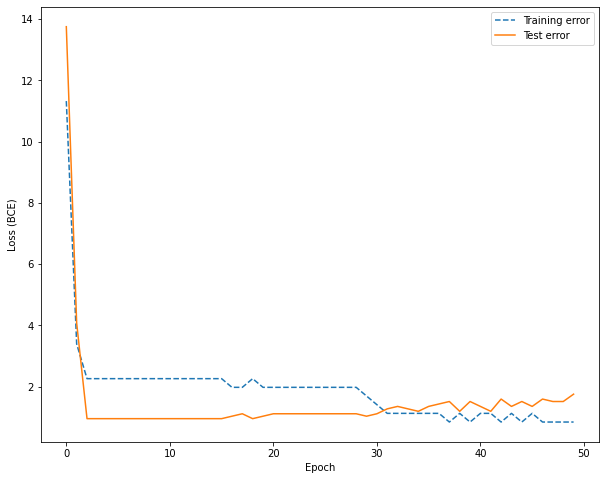

In [ ]:
plot_learning_curves(train_loss_M3, test_loss_M3, 50, 'Loss (BCE)')

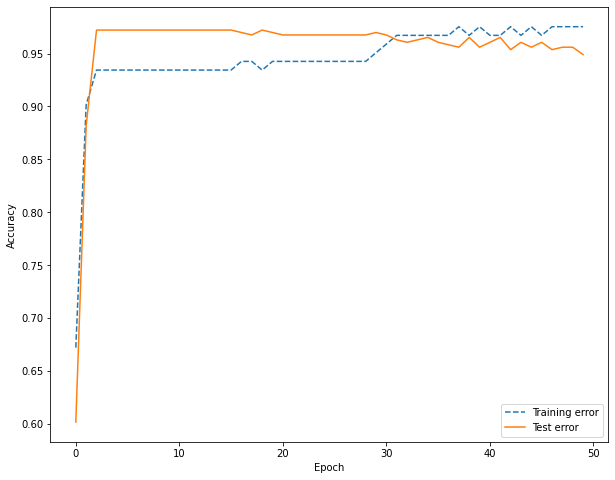

In [ ]:
plot_learning_curves(train_scores_M3, test_scores_M3, 50, 'Accuracy')

## Defining model for regression task

In [ ]:
def mee(true_target, predicted_target): #assuming target is 2-dim matrix with x and y as columns
    l = true_target.shape[0]
    res = 0
    
    for p in range(l): #for p-th pattern in l (number of samples)
        x_diff = np.square(true_target[p,0] - predicted_target[p,0]) #difference between the x value of the true and predicted target
        y_diff = np.square(true_target[p,1] - predicted_target[p,1]) #difference between the y values of true and predicted target
        sum_term = x_diff + y_diff
        res = res + np.sqrt(sum_term)
    res = res / l
    
    #return np.average([np.sqrt(np.square(true_target[p,0] - predicted_target[p,0]) + np.square(true_target[p,1] - predicted_target[p,1])) for p in range(l)]) #compact form
    return res

In [ ]:
from sklearn.preprocessing import StandardScaler

class OutputDataset(Dataset):
    def __init__(self, X, y, scale_data=True):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            # Apply scaling if necessary
            if scale_data:
                X = StandardScaler().fit_transform(X)
                self.X = torch.from_numpy(X).float()
                y = torch.from_numpy(y).float()
                self.y = y.unsqueeze(1)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [ ]:
#define a neural network
class RegressionNet(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2, n_output):
        super(RegressionNet, self).__init__()
        self.layer_in = nn.Linear(n_input, n_hidden1)
        self.layer_1 = nn.Linear(n_hidden1, n_hidden2) 
        self.layer_out = nn.Linear(n_hidden2, n_output) 
        
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid =  nn.Sigmoid()
        #self.dropout = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = nn.BatchNorm1d(n_hidden2)

    def forward(self, inputs):
        x = self.relu(self.layer_in(inputs))
        #x = self.batchnorm1(x)
        x = self.relu(self.layer_1(x))
        #x = self.batchnorm2(x)
        #x = self.dropout(x)

        x = self.layer_out(x)
        #out1 = self.last_fc(x)
        
        return x

In [ ]:
#function to define the train phase
def TrainPhase_Cup(epochs, model, aggregated_losses, aggregated_accuracy, data_train, loss, optimizer):
    model.train()
    i = epochs

    epoch_loss = 0
    epoch_acc = 0
    
    for X_batch, y_batch in data_train:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
       
        y_pred = model(X_batch)
        #y_pred1 = model(X_batch)
        
        single_loss = loss(y_pred, y_batch)
        #single_loss1 = loss1(y_pred1, y_batch1)
        #single_loss2 = loss2(y_pred2, y_batch2)
        #single_loss = torch.add(single_loss1, single_loss2)

        #acc = binary_acc(y_pred, y_batch)
             
        single_loss.backward()
        optimizer.step()
        
        epoch_loss += single_loss.item()
        #epoch_acc += acc.item()
        
    aggregated_losses.append(epoch_loss/len(data_train))
    #aggregated_accuracy.append((epoch_acc/len(data_train))/100)
    print(f'TRAIN - Epoch {i+0:03}: | Loss: {epoch_loss/len(data_train):.5f}')

    #aggregated_losses.append(single_loss.item())
    #aggregated_accuracy.append(acc/100)
    #print(f'TRAIN - Epoch {i+0:03}: | Loss: {single_loss.item():.5f} | Acc: {acc:.3f}')
    
    return model, aggregated_losses

In [ ]:
#function to define the evaluate phase
def Evaluate_Cup(epochs, model, aggregated_losses, aggregated_accuracy, data_test, loss_f):
    
    i = epochs
    y_pred_list = []
    model.eval()
        
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for X_batch, y_batch in data_test:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_test_pred = model(X_batch)
            #y_pred1, y_pred2 = model(X_batch)

            loss = loss_f(y_test_pred, y_batch)
            #loss1 = loss_f1(y_pred1, y_batch1)
            #loss2 = loss_f2(y_pred2, y_batch2)
            #loss = torch.add(loss1, loss2)
            
            #acc = binary_acc(y_test_pred, y_batch)

            epoch_loss += loss.item()
            #epoch_loss += loss.item()*X_batch.size(0)
            #epoch_acc += acc.item()

            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
    

    #y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

    aggregated_losses.append(epoch_loss/len(data_test))
    #aggregated_accuracy.append((epoch_acc/len(data_test))/100)
    #print(f'TEST - Epoch {i+0:03}: | Loss: {epoch_loss/len(data_test):.5f} | Acc: {epoch_acc/len(data_test):.3f}')
    print(f'VALIDATION - Epoch {i+0:03}: | Loss: {epoch_loss/len(data_test):.5f}')
    
    return aggregated_losses
    

In [ ]:
#function to define the evaluate phase
def Result_Cup(model, X_batch):
    
    y_pred_list = []
    model.eval()

    with torch.no_grad():
        #for X_batch, _ in data_test:
        X_batch = X_batch.to(device)

        y_test_pred = model(X_batch)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy()) 

    #y_pred_list = [a.squeeze().tolist() for a in y_pred_list]    
    return y_pred_list
    

## ML-Cup dataset

### Loading the training and blind test dataset

In [ ]:
df_visual = pd.read_csv('./data/ML-CUP21-TR.csv', usecols=[11,12], names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = pd.read_csv('./data/ML-CUP21-TR.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = df_task_tr[7:] # remove first 7 rows of comments
df_visual = df_visual[7:]

df_blind_ts = pd.read_csv('./data/ML-CUP21-TS.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10'])
df_blind_ts = df_blind_ts[7:]
df_blind_ts.drop(labels="idx", axis=1, inplace=True)
#blind_ts = df_blind_ts.values

In [ ]:
df_task_tr.drop(labels="idx", axis=1, inplace=True)

In [ ]:
y = df_task_tr[['x','y']]
X = df_task_tr.drop(labels=['x','y'], axis=1)
X_test = df_blind_ts

print(y.shape)

(1477, 2)


### Internal Test set
We split the training set obtaining an internal test set composed of the 10% of the training set, we will use this internal test set to test the generalization error

In [ ]:
#prepare validation set
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.1, random_state=420)
print(f"X shape: {X_train.shape}")
print(f"X validation shape: {X_validation.shape}")
print(f"y shape: {y_train.shape}")
print(f"y validation shape: {y_validation.shape}")

X shape: (1329, 10)
X validation shape: (148, 10)
y shape: (1329, 2)
y validation shape: (148, 2)


In [ ]:
y_train = y_train[['x', 'y']]

y_validation = y_validation[['x', 'y']]

print(f"First output train shape: {y_train.shape}")
print(f"First output validation shape: {y_validation.shape}")

First output train shape: (1329, 2)
First output validation shape: (148, 2)


#create tensor for train and test data 
X_train = X_train.values #returns a ndarray
X_test = X_test.values
X_validation = X_validation.values

x_tensor =  torch.from_numpy(X_train).float()
y_tensor =  torch.from_numpy(y_train.values).float()
xval_tensor =  torch.from_numpy(X_validation).float()
yval_tensor =  torch.from_numpy(y_validation.values).float()

xtest_tensor =  torch.from_numpy(X_test).float()

In [ ]:
BATCH_SIZE = 1 #########TODO

NameError: name 'best_model' is not defined

In [ ]:
#prepare dataloader for training
#y1_tensor = y1_tensor.unsqueeze(1)
#y2_tensor = y2_tensor.unsqueeze(1)

#print(yval1_tensor.shape)
#print(yval2_tensor.shape)

#train_ds = TensorDataset(x_tensor, y_tensor)
train_ds = OutputDataset(X_train.values, y_train.values)
#train_ds = MultiOutputDataset(X_train, y1_train.values, y2_train.values)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
#prepare dataloader for validation 
#yval1_tensor = yval1_tensor.unsqueeze(1)
#yval2_tensor = yval2_tensor.unsqueeze(1)

#val_ds = TensorDataset(xval_tensor, yval_tensor)
val_ds = OutputDataset(X_validation.values, y_validation.values)
#val_ds = MultiOutputDataset(xval_tensor, y1_validation.values, y2_validation.values)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
#prepare dataloader for evaluating 
#ytest_tensor = ytest_tensor.unsqueeze(1)
X_test = StandardScaler().fit_transform(X_test.values)
xtest_tensor= torch.from_numpy(X_test).float()

test_ds = TensorDataset(xtest_tensor)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

In [ ]:
BATCH_SIZE = 64 #best_model.batch_size
LEARNING_RATE = 0.001 #best_model.lr
MOMENTUM = best_model.optimizer__momentum
NESTEROV = best_model.optimizer__nesterov
L2 = best_model.optimizer__weight_decay
EPOCHS = 150 #best_model.max_epochs
UNITS = best_model.module__hidden_units
OPTIMIZER = best_model.optimizer

### Training and evaluate

In [ ]:
#define the model
model = RegressionNet(X_train.shape[1], 100, 50, 2)
model.to(device)
print(model)

RegressionNet(
  (layer_in): Linear(in_features=10, out_features=100, bias=True)
  (layer_1): Linear(in_features=100, out_features=50, bias=True)
  (layer_out): Linear(in_features=50, out_features=2, bias=True)
  (relu): ReLU(inplace=True)
  (sigmoid): Sigmoid()
  (batchnorm1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
#define the loss function 
loss_function1 = nn.MSELoss(reduction='mean')
#loss_function2 = nn.MSELoss(reduction='mean')
#define the optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=L2, dampening=DAMPENING, nesterov=NESTEROV)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
#prepare empty lists to store accuracy and loss results
losses_train = []
accuracies_train = []
losses_test = []
accuracies_test = []

#train and evaluate for each epoch
for epoch in range(1,EPOCHS+1): 
  model, losses_train = TrainPhase_Cup(epoch, model, losses_train, accuracies_train, train_loader, loss_function1, optimizer)
  #y_pred_test, losses_test, accuracies_test = Evaluate(epoch, model, losses_test, accuracies_test, test_loader, loss_function)
  losses_test = Evaluate_Cup(epoch, model, losses_test, accuracies_test, val_loader, loss_function1)
  
  print("##############################")

TRAIN - Epoch 001: | Loss: 218.75533
VALIDATION - Epoch 001: | Loss: 196.52307
##############################
TRAIN - Epoch 002: | Loss: 167.01573
VALIDATION - Epoch 002: | Loss: 126.84796
##############################
TRAIN - Epoch 003: | Loss: 89.79726
VALIDATION - Epoch 003: | Loss: 59.00142
##############################
TRAIN - Epoch 004: | Loss: 46.42454
VALIDATION - Epoch 004: | Loss: 45.88828
##############################
TRAIN - Epoch 005: | Loss: 40.05725
VALIDATION - Epoch 005: | Loss: 40.32966
##############################
TRAIN - Epoch 006: | Loss: 37.11889
VALIDATION - Epoch 006: | Loss: 38.67409
##############################
TRAIN - Epoch 007: | Loss: 36.29318
VALIDATION - Epoch 007: | Loss: 38.08452
##############################
TRAIN - Epoch 008: | Loss: 36.24532
VALIDATION - Epoch 008: | Loss: 37.76599
##############################
TRAIN - Epoch 009: | Loss: 35.89820
VALIDATION - Epoch 009: | Loss: 37.51951
##############################
TRAIN - Epoch 010: | Los

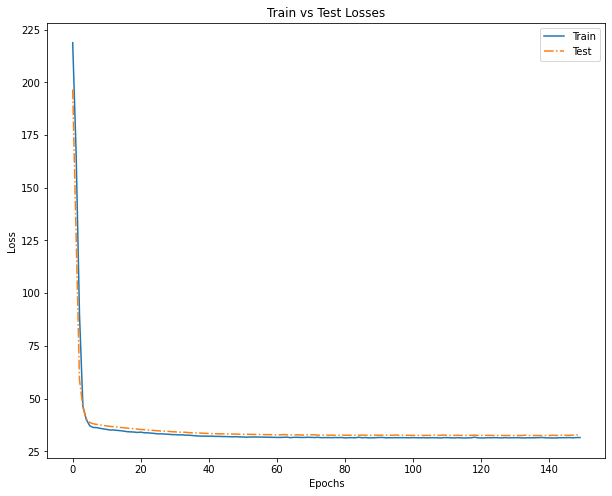

In [ ]:
#create a loss plot
plt.plot(losses_train,'-')
plt.plot(losses_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
 
plt.show()

In [ ]:
#create an accuracy plot
#plt.plot(accuracies_train,'-')
#plt.plot(accuracies_test,'-.')
#plt.xlabel('Epochs')
#plt.ylabel('Accuracy')
#plt.legend(['Train','Test'])
#plt.title('Train vs Test Accuracy')
 
#plt.show()

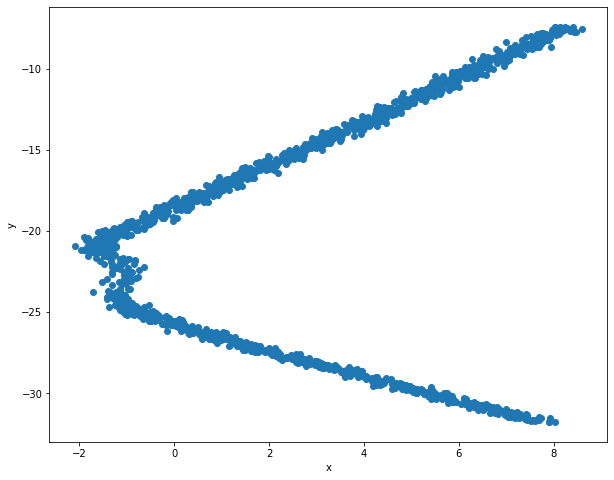

In [ ]:
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(df_visual['x'], df_visual['y'])

In [ ]:
predictions_blind = []
predictions_blind = Result_Cup(model, xtest_tensor)
predictions_blind

[array([[  3., -20.],
        [  3., -20.],
        [  3., -20.],
        ...,
        [  3., -20.],
        [  3., -20.],
        [  3., -20.]], dtype=float32)]

In [ ]:
def plot_coordinates(model, X, true_y = None):
    y_predicted = model.predict(X)
    y_predicted = pd.DataFrame(data=y_predicted, columns=["x", "y"])
    if not None:
        true_y = pd.DataFrame(data=true_y, columns=["x", "y"])
        plt.scatter(true_y['x'], true_y['y'], c='r', marker='*')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4')

In [ ]:
#plot_coordinates(model, X_internal_test, y_internal_test)

In [ ]:
#plot_coordinates(model, X_all, y_all)

In [ ]:
#plot_coordinates(model, blind_ts)
y_predicted = pd.DataFrame(data=predictions_blind, columns=["x", "y"])
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4')

ValueError: Must pass 2-d input. shape=(1, 540, 2)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d9d840c9-75b3-4185-bb01-105f5cca8d83' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>